# [추천 시스템 입문편] Content-Based Recommendation 2

## 샘플 유저의 평점을 학습 데이터와 평가 데이터로 나누기

In [1]:
# 필요한 패키지 설치
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 읽어오기
ratings = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/추천 시스템 입문편/data/ml-latest-small/ratings_update.p')
genres = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/추천 시스템 입문편/data/ml-latest-small/genres.p')

In [3]:
# 샘플 유저 정하기
user414 = ratings[ratings['userId'] == 414]
user414.sample()

,userId,movieId,rating,timestamp
64142,414,6442,5.0,2003-06-10 17:25:07


In [4]:
# 샘플 유저 414에 genres 데이터를 이너 조인으로 붙이기
# 샘플 유저 414의 movieId와 genres의 index(movieId)를 기준으로 조인
user414 = user414.merge(genres, left_on='movieId', right_index=True)
user414.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
64299,414,7884,4.0,2006-09-15 21:23:12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# 샘플 유저 414의 데이터를 모델을 훈련하는 장르, 평점 데이터와 성능을 테스트하는 장르, 평점 데이터로 나눠주기
from sklearn.model_selection import train_test_split

In [6]:
# 샘플 유저 414의 장르 정보와 평점 정보를 따로 나눠주기
# X_train, X_test : 장르 정보
# y_train, y_test : 평점 정보
X_train, X_test, y_train, y_test = train_test_split(user414[genres.columns], user414['rating'], random_state=42, test_size=0.1)

In [7]:
# 여기서 장르 정보는 평점 정보를 예측하기 위해 필요한 정보들인 특성이며, 평점 정보는 정답인 레이블을 나타냄
# feature, X : y를 예측하기 위해 필요한 정보들 (장르 정보)
print(X_train.shape)
print(X_test.shape)

# label, y : 정답 (평점 정보)
print(y_train.shape)
print(y_test.shape)

(2428, 20)
(270, 20)
(2428,)
(270,)


In [8]:
X_train.sample()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
64635,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0


In [9]:
X_test.sample()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
64026,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [10]:
y_train.sample()

63393    4.0
Name: rating, dtype: float64

In [11]:
y_test.sample()

63076    4.0
Name: rating, dtype: float64

## 샘플 유저의 프로필 만들기

In [12]:
#  Linear Model 모델 생성하기
from sklearn.linear_model import LinearRegression

In [13]:
reg = LinearRegression()

In [14]:
# 샘플 유저 414의 프로필 훈련 시키기
reg.fit(X_train, y_train)

LinearRegression()

In [15]:
# Linear Model의 각 장르에 대한 계수 살펴보기
reg.coef_

array([ 1.04932187, -0.16519465,  0.12503892,  0.66646026, -0.29618416,
       -0.06757262,  0.1753061 ,  0.43261644,  0.31547858,  0.05636728,
        0.29277987, -0.1206128 ,  0.35832908,  0.03551429,  0.25847584,
       -0.01912917,  0.1634995 , -0.13939399,  0.43835199,  0.29161535])

In [16]:
# Linear Model의 절편 살펴보기
reg.intercept_

3.200678127757581

In [17]:
# 샘플 유저 414의 장르에 따른 계수 알아보기
# 아무런 장르에 대한 평점이 없을 경우 절편 값을 주게됨
# 평점이 있는 장르의 경우 절편 - 계수 * 1 (절편 값에서 계수를 차감한 값을 주게 됨)
list(zip(X_train.columns, reg.coef_))

[('(no genres listed)', 1.0493218722424231),
 ('Action', -0.16519464857050492),
 ('Adventure', 0.1250389160090738),
 ('Animation', 0.6664602615156161),
 ('Children', -0.29618416468814773),
 ('Comedy', -0.06757261930358603),
 ('Crime', 0.17530609839293299),
 ('Documentary', 0.43261644111066383),
 ('Drama', 0.31547857708591487),
 ('Fantasy', 0.05636727626646813),
 ('Film-Noir', 0.29277987382219783),
 ('Horror', -0.12061279616418584),
 ('IMAX', 0.35832907660236973),
 ('Musical', 0.035514285435159554),
 ('Mystery', 0.2584758423706581),
 ('Romance', -0.019129170010524225),
 ('Sci-Fi', 0.1634994999246448),
 ('Thriller', -0.13939399479870954),
 ('War', 0.4383519944116418),
 ('Western', 0.29161535403606054)]

In [18]:
# 샘플 유저 414의 액션 장르 영화에 대한 예상 평점 알아보기
# baseline score + Action 장르에 대한 cofficient
# Action 장르만 있을 때의 예상 평점
reg.intercept_ + reg.coef_[1]

3.035483479187076

In [19]:
# 샘플 유저 414의 액션 + 어드벤처 장르 영화에 대한 예상 평점 알아보기
# baseline score + Action 장르에 대한 cofficient + Adventure 장르에 대한 cofficient
# # Action 장르와 Adventure 장르가 동시에 있을 때의 예상 평점
reg.intercept_ + reg.coef_[1] + reg.coef_[2]

3.16052239519615

In [20]:
%matplotlib inline

<Axes: >

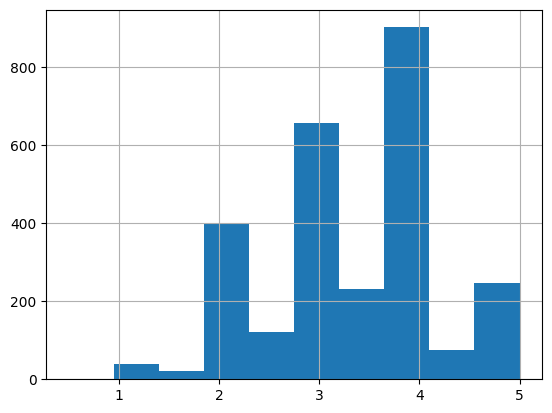

In [21]:
# 샘플 유저 414의 유저 프로필 해석해보기
# 샘플 유저 414의 평점 시각화하기
user414['rating'].hist()

<Axes: >

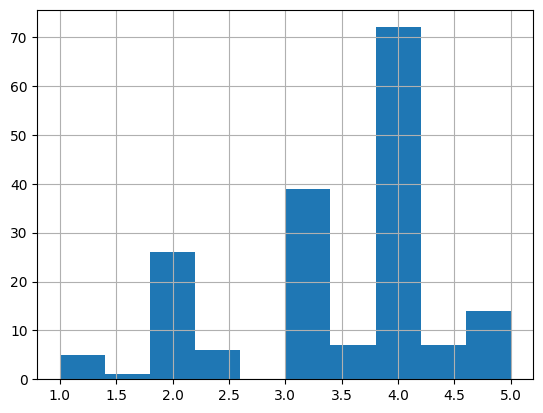

In [22]:
# 샘플 유저 414가 싫어하는 장르의 평점 시각화하기
user414.loc[user414['Children'] == 1, 'rating'].hist()

<Axes: >

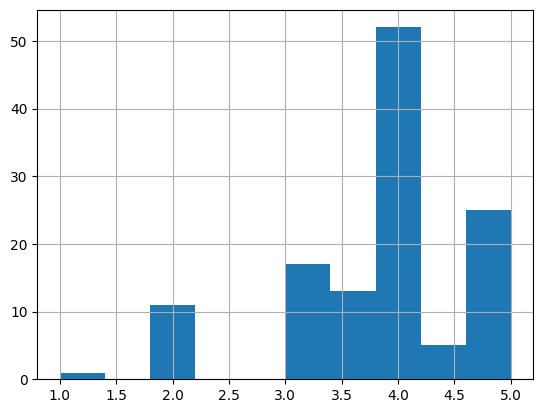

In [23]:
# 샘플 유저 414가 좋아하는 장르의 평점 시각화하기
user414.loc[user414['War'] == 1, 'rating'].hist()

In [24]:
# 샘플 유저 414의 평점 예측하기
predict = reg.predict(X_test)

In [25]:
predict

array([3.13310551, 3.37676271, 3.13310551, 3.30841161, 3.5161567 ,
       3.55206881, 3.42164392, 3.29660501, 3.57252398, 3.02953288,
       3.5161567 , 2.99371151, 3.37676271, 3.21997254, 3.3240219 ,
       3.05226641, 3.5161567 , 3.55206881, 3.48582219, 3.51446156,
       3.49702753, 3.42945492, 3.9545087 , 3.6796562 , 3.28928244,
       3.5161567 , 3.9545087 , 3.94993865, 2.81779217, 3.6914628 ,
       2.95355578, 3.13310551, 3.05958898, 3.63329457, 3.32987143,
       2.89608948, 3.5161567 , 3.3240219 , 3.66052703, 3.44858409,
       2.89608948, 3.21078958, 3.38687416, 3.25814442, 2.92880291,
       3.86986936, 3.5161567 , 3.64119562, 3.50010648, 3.0211284 ,
       3.49702753, 3.13310551, 3.11397634, 3.5161567 , 3.44858409,
       3.19898298, 3.44858409, 3.42945492, 3.13310551, 3.38687416,
       3.54295698, 2.83692134, 3.13310551, 3.75086918, 3.93537953,
       3.42945492, 3.13310551, 3.1846279 , 3.5161567 , 3.55206881,
       3.07139558, 2.83692134, 3.64119562, 3.44858409, 3.51615

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
# RMSE로 평가
mse = mean_squared_error(y_test, predict)
rmse = np.sqrt(mse)
rmse

0.8764429330252587

## 전체 유저의 프로필 만들기

In [28]:
#  전체 데이터로 확장
ratings = ratings.merge(genres, left_on='movieId', right_index=True)
ratings.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
53994,356,4878,5.0,2008-12-13 04:41:33,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


In [29]:
train, test = train_test_split(ratings, random_state=42, test_size=0.1)

In [34]:
user_profile_list = []

# 각 유저마다 유저 프로필 계산
for userId in train['userId'].unique():
    # 샘플 유저 정하기 반복
    user = train[train['userId'] == userId]
    # features, label 나눠주기
    X_train = user[genres.columns]
    y_train = user['rating']

    # Linear Model 모델 생성하기
    reg = LinearRegression()
    # 유저 프로필 훈련 시키기
    reg.fit(X_train, y_train)

    # 절편과 계수 (리스트를 flattern하게 만들어서) 저장
    user_profile_list.append([reg.intercept_, *reg.coef_])

In [37]:
# 표 형식으로 변환 
user_profile = pd.DataFrame(user_profile_list, index=train['userId'].unique(), columns=['intercept', *genres.columns])

In [41]:
# 실수 형태로 변환
pd.set_option('float_format', '{:f}'.format)

In [42]:
# 전체 데이터에 대한 유저 프로필
user_profile

,intercept,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
177,3.291575,0.000000,-0.188919,-0.102875,0.384241,-0.264550,-0.064312,0.176477,0.491395,0.215402,...,-1.072695,-0.237858,0.505259,0.174402,0.323602,0.110394,-0.147821,-0.054023,0.176728,0.038149
318,3.783040,0.466960,-0.108882,-0.117776,0.107579,-0.036769,0.081844,0.016880,0.208306,0.082597,...,0.150064,-0.215824,0.058228,-0.122378,-0.034600,-0.109415,-0.138571,-0.060873,0.050784,0.299577
610,3.649896,0.000000,-0.130928,0.126858,0.341187,-0.323753,0.042576,0.108913,0.464460,0.255044,...,0.522554,-0.119444,0.016682,0.183726,0.155756,-0.050713,0.036119,-0.143213,-0.002708,0.050753
105,4.183209,0.650125,-0.271820,-0.042206,0.335013,-0.132330,-0.099004,0.213280,0.255017,0.023691,...,-0.070731,-0.008883,0.011783,-0.168632,0.138029,-0.146421,-0.043225,-0.086637,0.082700,-0.079970
522,3.823975,0.000000,-0.171447,0.136491,0.531269,-2.121521,-0.228656,0.403201,0.540353,-0.086566,...,-0.843273,0.609925,0.035229,0.738242,0.068855,0.126230,0.214059,0.047242,0.024234,1.055031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.853471,-0.000000,-1.392857,3.830441,-0.000000,-0.000000,1.792390,2.160547,0.000000,1.594126,...,0.000000,1.854139,0.000000,0.000000,0.000000,-0.817757,-1.241989,1.413885,2.005007,5.857143
145,2.608734,0.000000,-0.866310,0.298574,0.717647,0.717647,-0.201426,0.242424,0.000000,0.270053,...,0.000000,0.000000,-0.177362,-0.141176,1.181818,0.393048,-0.065954,0.967023,0.154189,0.822638
107,4.377789,0.000000,0.104175,-0.228587,0.431490,0.741329,-0.634393,-0.479404,-0.000000,0.944232,...,0.000000,-1.322021,0.000000,-0.000000,0.791943,-0.612316,-1.045320,-0.796990,-0.583106,0.088386
37,4.577049,-0.000000,-0.219672,-0.560656,0.065574,-0.360656,0.504918,-0.449180,0.000000,-0.396721,...,0.000000,0.750820,1.380328,-0.360656,0.000000,0.000000,0.104918,0.121311,0.000000,0.380328


In [43]:
# 나의 유저 프로필 찾아보기
user_profile.loc[1000]

intercept            5.000000
(no genres listed)   0.000000
Action               0.000000
Adventure            0.000000
Animation            0.000000
Children             0.000000
Comedy               0.000000
Crime                0.000000
Documentary          0.000000
Drama                0.000000
Fantasy              0.000000
Film-Noir            0.000000
Horror               0.000000
IMAX                 0.000000
Musical              0.000000
Mystery              0.000000
Romance              0.000000
Sci-Fi               0.000000
Thriller             0.000000
War                  0.000000
Western              0.000000
Name: 1000, dtype: float64

## 전체 유저의 평점 예측

In [44]:
# intercept와 장르별 coef로 구성
user_profile.sample()

,intercept,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
330,3.590761,0.000000,-0.073217,0.284441,0.109898,-0.001238,-0.072224,0.247187,-0.000000,0.181062,...,-0.000000,0.636128,-0.214249,0.326928,0.225712,-0.052965,-0.255800,-0.237539,0.286698,0.657769


In [51]:
# 평점 예측
for idx, row in test.iterrows():
    # userId
    user = row['userId']
    # 유저 프로필의 장르 별 계수 * 아이템(영화)의 장르 정보
    print(user)
    print(row['movieId'])
    print(row[genres.columns])
    print(user_profile.loc[user, genres.columns] * row[genres.columns])
    break

57
1882
(no genres listed)    0
Action                1
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                1
Thriller              1
War                   0
Western               0
Name: 8313, dtype: object
(no genres listed)    0.000000
Action               -0.127489
Adventure             0.000000
Animation             0.000000
Children             -0.000000
Comedy                0.000000
Crime                 0.000000
Documentary           0.000000
Drama                 0.000000
Fantasy               0.000000
Film-Noir             0.000000
Horror               -0.000000
IMAX                 -0.000000
Musical               0.000000
Mystery               0.000000
Romance              

In [52]:
# for문 진행 상황 확인
from tqdm import tqdm_notebook

In [54]:
# 직접 절편과 장르 점수를 더해서 유저에 따른 특정 장르에 대한 평점 예측하기
predict = []

for idx, row in tqdm_notebook(test.iterrows()):
    user = row['userId'] # test row의 user
    intercept = user_profile.loc[user, 'intercept'] # 해당 user의 user_profile에서 intercept
    genre_score = sum(user_profile.loc[user, genres.columns] * row[genres.columns]) # 해당 movie의 장르에서 비롯되는 예상 점수
    # 절편 + 유저 프로필의 장르 별 계수 * 아이템(영화)의 장르 정보
    expected_score = intercept + genre_score
    predict.append(expected_score)

0it [00:00, ?it/s]

## 모델 평가

In [55]:
test['predict'] = predict

In [57]:
# RMSE로 평가
rmse = np.sqrt(mean_squared_error(test['rating'], test['predict']))
rmse

0.9691037996431178

## 오버피팅

In [58]:
# 데이터가 적은 유저의 경우, 데이터의 갯수와 features의 갯수가 거의 같아
# 계수 계산이 정확하지 않으므로 오버피팅이 발생하여
# 새로운 데이터를 사용하여 예측 시 성능이 떨어짐을 볼 수 있음

# 해결책 1) 빈도수가 낮은 장르를 없애 features 수를 줄여 설명해야 하는 요소를 줄이기
# 해결책 2) 상관관계가 높은 장르들 (자주 같이 등장하는 장르들)을 합치기
# 해결책 3) 데이터가 적은 유저의 경우만 계수 대신 전체 평균, 유저 별 평균,  Content-Based Recommendation 1 사용
# → 모델 앙상블
# 해결책 4) 정규화가 가능한 Linear Model (Ridge, Lasso 등) 사용하여 중요하지 않는 변수 탈락 시키기

## Lasso 모델 적용

In [59]:
from sklearn.linear_model import Lasso

In [60]:
# Lasso 모델을 통해 절편과 계수를 업데이트하기 위한 새로운 유저 프로필 생성하기 
user_profile_list = []

# 각 유저마다 유저 프로필 계산
for userId in train['userId'].unique():
    # 샘플 유저 정하기 반복
    user = train[train['userId'] == userId]
    # features, label 나눠주기
    X_train = user[genres.columns]
    y_train = user['rating']

    # alpha를 설정하여 Lasso 모델 생성하기
    reg = Lasso(alpha=0.3)
    # 유저 프로필 훈련 시키기
    reg.fit(X_train, y_train)

    # 절편과 계수 (리스트를 flattern하게 만들어서) 저장
    user_profile_list.append([reg.intercept_, *reg.coef_])

In [61]:
# 표 형식으로 변환 
user_profile_lasso = pd.DataFrame(user_profile_list, index=train['userId'].unique(), columns=['intercept', *genres.columns])
# 중요하지 않은 장르의 계수는 0이 됨
# intercept로 평점을 알려주거나 다른 features (장르가 아닌 감독, 배우 등의 선호도)를 발견하여 사용함
user_profile_lasso

,intercept,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
177,3.371498,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000
318,3.756654,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
610,3.687869,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
105,4.131376,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
522,3.853261,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3.555556,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
145,3.350000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
107,3.892857,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
37,4.277778,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000


In [62]:
# 직접 절편과 장르 점수를 더해서 유저에 따른 특정 장르에 대한 평점 예측하기
predict = []

for idx, row in tqdm_notebook(test.iterrows()):
    user = row['userId'] # test row의 user
    intercept = user_profile_lasso.loc[user, 'intercept'] # 해당 user의 user_profile에서 intercept
    genre_score = sum(user_profile_lasso.loc[user, genres.columns] * row[genres.columns]) # 해당 movie의 장르에서 비롯되는 예상 점수
    # 절편 + 유저 프로필의 장르 별 계수 * 아이템(영화)의 장르 정보
    expected_score = intercept + genre_score
    predict.append(expected_score)

0it [00:00, ?it/s]

In [63]:
test['predict_lasso'] = predict

In [64]:
test

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,predict,predict_lasso
8313,57,1882,2.000000,2000-08-09 05:30:10,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,2.895183,3.409836
3424,21,34162,3.000000,2014-08-09 20:54:57,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,3.347892,3.271357
33637,227,109487,3.500000,2015-11-11 02:42:47,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,4.071363,4.213415
100232,610,51709,5.000000,2016-11-19 08:45:47,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,3.720977,3.687869
77733,483,30749,4.000000,2007-05-05 09:54:04,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3.893810,3.616972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39614,274,2273,2.500000,2007-02-18 00:31:13,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,3.215805,3.241619
49446,318,48997,3.500000,2014-10-18 18:28:31,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.821645,3.756654
48014,311,6333,3.000000,2003-07-10 16:26:57,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,3.490101,2.650000
44225,294,2167,3.000000,2000-08-18 21:28:04,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,2.865734,2.623410


In [65]:
# RMSE로 평가
# 오버피팅이 개선됨
rmse = np.sqrt(mean_squared_error(test['rating'], test['predict_lasso']))
rmse

0.9365114511185116